<a href="https://colab.research.google.com/github/ngminh124/traffic-sign-detection/blob/main/TrafficSignDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
from google.colab import files
from google.colab import drive
import os

# Gắn kết Google Drive trước để kiểm tra dữ liệu
try:
    drive.mount('/content/drive', force_remount=True)
except Exception as e:
    print(f"Lỗi khi gắn kết Google Drive: {e}")
    raise

# Kiểm tra xem dữ liệu có tồn tại trong Drive hay không
dataset_path = '/content/drive/MyDrive/road-sign-detection'

if not os.path.exists(dataset_path):
    print("Không tìm thấy dữ liệu trong Drive. Đang tải và giải nén...")

    # Tải lên khóa API Kaggle
    try:
        uploaded = files.upload()
        if 'kaggle.json' not in uploaded:
            raise FileNotFoundError("Vui lòng tải lên tệp kaggle.json.")
    except Exception as e:
        print(f"Lỗi khi tải lên khóa API Kaggle: {e}")
        raise

    # Thiết lập Kaggle
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    !kaggle --version

    # Tải dữ liệu từ Kaggle
    !kaggle datasets download -d andrewmvd/road-sign-detection -p /content/

    # Xóa các thư mục annotations và images nếu đã tồn tại
    !rm -rf /content/annotations /content/images

    # Giải nén dữ liệu
    !unzip /content/road-sign-detection.zip -d /content/

    # Sao chép dữ liệu vào Drive
    !mkdir -p /content/drive/MyDrive/road-sign-detection/
else:
    print("Dữ liệu đã có sẵn trong Drive. Không cần tải lại.")
if not os.path.exists('/content/images') or not os.path.exists('/content/annotations'):
    print("Không tìm thấy thư mục images hoặc annotations trong /content/. Đang sao chép từ Drive...")
    if os.path.exists(os.path.join(dataset_path, 'images')) and os.path.exists(os.path.join(dataset_path, 'annotations')):
        !cp -r /content/drive/MyDrive/road-sign-detection/images /content/
        !cp -r /content/drive/MyDrive/road-sign-detection/annotations /content/
        print("Đã sao chép dữ liệu từ Drive sang /content/.")
    else:
        print("Lỗi: Không tìm thấy thư mục images hoặc annotations trong Drive. Vui lòng kiểm tra lại.")
else:
    print("Thư mục images và annotations đã tồn tại trong /content/. Bỏ qua bước sao chép.")

Mounted at /content/drive
Dữ liệu đã có sẵn trong Drive. Không cần tải lại.
Thư mục images và annotations đã tồn tại trong /content/. Bỏ qua bước sao chép.


In [41]:
import time
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from skimage.transform import resize
from skimage import feature
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [42]:
# đọc 1 file xml cụ thể sử dụng ElementTree

xml_file = '/content/annotations/road0.xml'
tree = ET.parse(xml_file)
root = tree.getroot()
folder_name = root.find('folder').text
filename = root.find('filename').text
print (f'Folder: {folder_name}')
print(f'Filename: {filename}')

# đọc tất cả các object có trong thẻ object của file xml đó

for obj in root.findall('object'):
  classname=obj.find('name').text
  xmin=int(obj.find('bndbox/xmin').text)
  ymin=int(obj.find('bndbox/ymin').text)
  xmax=int(obj.find('bndbox/xmax').text)
  ymax=int(obj.find('bndbox/ymax').text)
print(f'Class name: {classname}')
print(f'Bounding box: {(xmin, ymin, xmax, ymax)}')

Folder: images
Filename: road0.png
Class name: trafficlight
Bounding box: (98, 62, 208, 232)


In [43]:
# đọc toàn bộ datasets
# đọc qua các file annotations bằng hàm listdr của module os
# đọc ảnh thông qua thư viện opencv
annotations_dir = '/content/annotations'
img_dir = '/content/images'
img_lst = []
label_lst = []
for xml_file in os.listdir (annotations_dir):

  xml_filepath = os.path.join(annotations_dir, xml_file)

  tree=ET.parse(xml_filepath)

  root=tree.getroot()

  folder = root.find('folder').text

  img_filename = root.find('filename').text

  img_filepath = os.path.join(img_dir, img_filename)

  img = cv2.imread(img_filepath)
  for obj in root.findall('object'):
      classname = obj.find('name').text
      if classname == 'trafficlight':
          continue
      xmin = int(obj.find('bndbox/xmin').text)
      ymin= int(obj.find('bndbox/ymin').text)
      xmax = int(obj.find('bndbox/xmax').text)
      ymax = int(obj.find('bndbox/ymax').text)
      object_img = img[ymin:ymax, xmin: xmax]
      img_lst.append(object_img)
      label_lst.append(classname)
print(f'Number of images in datasets: {len(img_lst)}')
print(f'Classes names: {list(set(label_lst))}')

Number of images in datasets: 1074
Classes names: ['crosswalk', 'stop', 'speedlimit']


In [44]:
print(f'original shape: {img_lst[0].shape}')

original shape: (26, 27, 3)


In [45]:
# chuyển shape sử dụng flatten của ảnh gốc ban đầu từ vector 3D thành vector 1D để phục vụ cho việc train theo model SVM
flattened_img =img_lst[0].flatten()
print(f'flattend shape: {flattened_img.shape}')

flattend shape: (2106,)


In [46]:
# sử dụng HOG thay vì flatten
def preprocess_img(img):
  if len(img.shape) > 2:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img=img.astype(np.float32)
  resized_img = resize(
      img,
      output_shape=(32, 32),
      anti_aliasing=True
  )
  hog_feature = feature.hog(
      resized_img,
      orientations=9,
      pixels_per_cell=(8, 8),
      cells_per_block=(2, 2),
      transform_sqrt=True,
      block_norm="L2",
      feature_vector=True
  )
  return hog_feature

In [47]:
img_features_lst =[]
for img in img_lst:
  hog_feature = preprocess_img(img)
  img_features_lst.append(hog_feature)
img_features= np.array(img_features_lst)
print("X shape: ")
print(img_features.shape)

X shape: 
(1074, 324)


In [48]:
# encode label thành dạng số để phục vụ cho việc train
label_encoder= LabelEncoder()
encoded_labels= label_encoder.fit_transform(label_lst)
print(label_encoder.classes_)
encoded_labels

['crosswalk' 'speedlimit' 'stop']


array([0, 1, 1, ..., 0, 0, 1])

In [49]:
random_state=0
test_size=0.3
is_shuffle= True
X_train, X_val, y_train, y_val = train_test_split(
    img_features, encoded_labels,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [50]:
# thực hiện chuẩn hóa cho tập train và validate
scaler= StandardScaler()
X_train= scaler.fit_transform(X_train) # tính normalization mà fit trên tập train sau đó chuẩn hóa lại cho cả tập train và validate
X_val= scaler.transform(X_val)
X_train

array([[-0.33732262,  0.3281256 ,  0.770797  , ..., -0.2546631 ,
        -0.27083653, -0.11421215],
       [-0.59000504, -0.19402617, -0.02702975, ..., -0.5851218 ,
        -0.45722657, -0.6131916 ],
       [ 1.2676431 , -0.9536419 , -1.6127506 , ...,  0.47836393,
         0.44104502,  0.98570853],
       ...,
       [-0.40224078, -0.24112378,  1.7597884 , ..., -0.3542667 ,
        -0.15691106, -0.26655754],
       [-0.10172174, -1.2310601 , -1.5797845 , ...,  0.96458423,
         4.0510373 , -0.16232808],
       [-0.7668894 , -0.43513182,  0.74849004, ..., -0.4829194 ,
        -0.5087883 , -0.5426741 ]], dtype=float32)

In [51]:
# train và đánh giá model
clf= SVC(
    kernel='rbf',
    random_state=random_state,
    probability=True,
    C=0.5

)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_val)
score=accuracy_score(y_pred, y_val)
print(f'Evaluation results on val set')
print(f'Accurancy: {score}')

Evaluation results on val set
Accurancy: 0.9845201238390093


In [52]:
input_img = img_lst [1]
normalized_img = preprocess_img(input_img)
y_pred = clf.predict([normalized_img])[0]
print(f'Normal prediction: {y_pred}')
y_pred_prob = clf.predict_proba([normalized_img])
prediction = np.argmax(y_pred_prob)
y_pred_prob = [f'{p:.10f}' for p in y_pred_prob[0]]
print(f'Probability of each class: {y_pred_prob}')
print(f'Class with highest probability: {prediction})')

Normal prediction: 1
Probability of each class: ['0.0000000005', '0.9999746838', '0.0000253157']
Class with highest probability: 1)


In [53]:
# lấy danh sách các cửa sổ cắt được
def sliding_window(img, window_sizes, stride):
    img_height, img_width = img.shape[:2]
    windows = []
    for window_size in window_sizes:
        window_width, window_height = window_size
        for ymin in range(0, img_height - window_height + 1, stride):
            for xmin in range(0, img_width-window_width + 1, stride):
                xmax = xmin + window_width
                ymax = ymin + window_height
                windows.append([xmin, ymin, xmax, ymax])
    return windows

In [54]:
# scale ảnh để bắt được các object nhỏ so với kích thước ảnh
def pyramid(img, scale=0.8, min_size=(30, 30)):
    acc_scale = 1.0
    pyramid_imgs = [(img, acc_scale)]
    i = 0
    while True:
        acc_scale = acc_scale * scale
        h = int(img.shape[0] * acc_scale)
        w = int(img.shape[1] * acc_scale)
        if h<min_size(1) or w < min_size[0]:
            break
        img = cv2.resize(img, (w, h))
        pyramid_imgs.append((img, acc_scale * (scale ** i)))
        i += 1
    return pyramid_imgs

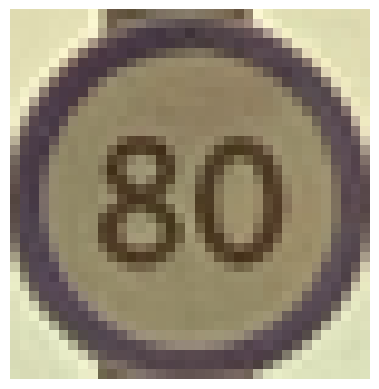

In [55]:
def visualize_bbox(img, bboxes, label_encoder):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for box in bboxes:
        xmin, ymin, xmax, ymax, predict_id, conf_score = box
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        classname=label_encoder.inverse_transform([predict_id])[0]
        label=f"{classname} {conf_score:.2f}"
        (w, h),_ =cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
        cv2.rectangle(img, (xmin, ymin - 20), (xmin + w, ymin), (0, 255, 0), -1)
        cv2.putText(img, label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)
plt.imshow(img)
plt.axis('off')
plt.show()